In [28]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import MinMaxScaler
from torch import nn
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 🚀 Welcome to Notebook 01! 🚀

In this notebook, we will take the housing data that we previously overfitted and now see if we can properly learn and generalize from it. 📊✨

## 🏠 Our Housing Data Features 🏠
- **in_sf**: 🌉 Is the house in San Francisco (SF) or not
- **beds**: 🛏 Number of bedrooms
- **bath**: 🛁 Number of bathrooms
- **price**: 💲 Price of the house
- **year_built**: 🏗 Year the house was built
- **sqft**: 📏 Square footage of the house
- **price_per_sqft**: 💰 Price per square foot
- **elevation**: 🌄 Elevation of the house

Let's dive in and explore how we can improve our model's performance! 🚀📈


In [10]:
#get data labels aka the first row 
with open('../data/sf_vs_nyc_house_data.csv', mode='r') as f:
    lables = f.readline()

lables = lables[:-1].split(sep=',')
print(lables)

df = pd.read_csv('../data/sf_vs_nyc_house_data.csv', skiprows=1, names=lables)

['in_sf', 'beds', 'bath', 'price', 'year_built', 'sqft', 'price_per_sqft', 'elevation']


In [11]:
df

,in_sf,beds,bath,price,year_built,sqft,price_per_sqft,elevation
0,0,2.0,1.0,999000,1960,1000,999,10
1,0,2.0,2.0,2750000,2006,1418,1939,0
2,0,2.0,2.0,1350000,1900,2150,628,9
3,0,1.0,1.0,629000,1903,500,1258,9
4,0,0.0,1.0,439000,1930,500,878,10
...,...,...,...,...,...,...,...,...
487,1,5.0,2.5,1800000,1890,3073,586,76
488,1,2.0,1.0,695000,1923,1045,665,106
489,1,3.0,2.0,1650000,1922,1483,1113,106
490,1,1.0,1.0,649000,1983,850,764,163


### 🔄 Change to Tensors and Normalize 🔄



In [12]:
#split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:].values, df.iloc[:, 0].values, test_size=0.2)

# normalize X_train and X_test
scaler_X = MinMaxScaler()
X_train = torch.tensor(scaler_X.fit_transform(X_train), dtype=torch.float32)
X_test = torch.tensor(scaler_X.transform(X_test), dtype=torch.float32)

# tensorizer :) y_train and y_test
y_train = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
y_test = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

### 📊 Building and Evaluating Three Models 📊

We will now do 3 models: a lightweight small MLP, a very wide MLP, and a deep MLP. Now that we are trying to generalize, we will be plotting the test set loss along with the learning. 📉✨ At the end of each one, we will evaluate the F1 score. 🏅


In [30]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.l0 = nn.Linear(7,5)
        self.relu0 = nn.ReLU()
        self.l1 = nn.Linear(5,3)
        self.relu1 = nn.ReLU()
        self.l2 = nn.Linear(3,1)
        self.out = nn.Sigmoid()

    
    def forward(self,X):
        x = self.l0(X)
        x = self.relu0(x)
        x = self.l1(x)
        x = self.relu1(x)
        logits = self.l2(x)
        x = self.out(logits)
        return x
    
model = MLP()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.BCELoss()


100%|██████████| 20000/20000 [00:05<00:00, 3457.45it/s]


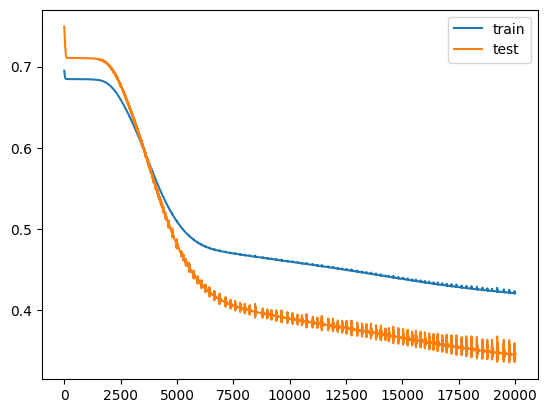

In [31]:
lossi = []
devlossi = []

for epoch in tqdm(range(20000)):
    out = model.forward(X_train)

    optimizer.zero_grad()
    loss = criterion(out, y_train)

    loss.backward()
    lossi.append(loss.item())
    optimizer.step()

    #evaluate the test loss but with no gradients
    with torch.no_grad():
        devout = model.forward(X_test)
        devloss  = criterion(devout, y_test)
        devlossi.append(devloss.item())

#plot the train loss and the test loss
plt.plot(lossi, label='train')
plt.plot(devlossi, label='test')
plt.legend()
plt.show()


In [32]:
#evaluation time
print('lossi',min(lossi))
print('devlossi',min(devlossi),'\n')



with torch.no_grad():
    pred = model.forward(X_test)

pred = pred.round() #our prediticons look like [.334, .638, .....] inorder to evalute we need them to be [0, 1, ....] so we round

print(classification_report(y_true=y_test, y_pred=pred))

lossi 0.42065903544425964
devlossi 0.3352712094783783 

              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90        53
         1.0       0.88      0.91      0.89        46

    accuracy                           0.90        99
   macro avg       0.90      0.90      0.90        99
weighted avg       0.90      0.90      0.90        99



### 🌐 Now for Our Very Wide Model 🌐


In [33]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.l0 = nn.Linear(7, 1024)  
        self.relu0 = nn.ReLU()
        self.l1 = nn.Linear(1024, 512)  
        self.relu1 = nn.ReLU()
        self.l2 = nn.Linear(512, 256) 
        self.relu2 = nn.ReLU()
        self.l3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        self.l4 = nn.Linear(128, 1)
        self.out = nn.Sigmoid()

    def forward(self, X):
        x = self.l0(X)
        x = self.relu0(x)
        x = self.l1(x)
        x = self.relu1(x)
        x = self.l2(x)
        x = self.relu2(x)
        x = self.l3(x)
        x = self.relu3(x)
        logits = self.l4(x)
        x = self.out(logits)
        return x

model = MLP()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.BCELoss()


100%|██████████| 20000/20000 [01:44<00:00, 191.54it/s]


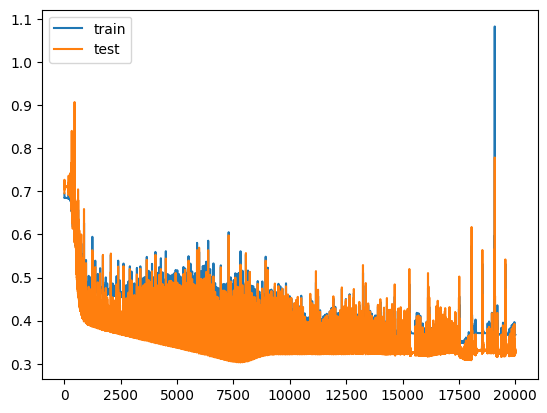

In [34]:
lossi = []
devlossi = []

for epoch in tqdm(range(20000)):
    out = model.forward(X_train)

    optimizer.zero_grad()
    loss = criterion(out, y_train)

    loss.backward()
    lossi.append(loss.item())
    optimizer.step()
    with torch.no_grad():
        devout = model.forward(X_test)
        devloss  = criterion(devout, y_test)
        devlossi.append(devloss.item())

plt.plot(lossi, label='train')
plt.plot(devlossi, label='test')
plt.legend()
plt.show()



In [35]:
print('lossi',min(lossi))
print('devlossi',min(devlossi),'\n')



with torch.no_grad():
    pred = model.forward(X_test)

pred = pred.round()

print(classification_report(y_true=y_test, y_pred=pred))

lossi 0.3428528308868408
devlossi 0.3028780221939087 

              precision    recall  f1-score   support

         0.0       0.86      0.91      0.88        53
         1.0       0.88      0.83      0.85        46

    accuracy                           0.87        99
   macro avg       0.87      0.87      0.87        99
weighted avg       0.87      0.87      0.87        99



### 🏞️ Now for the Deep Model 🏞️






In [36]:

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.l0 = nn.Linear(7, 32)  
        self.relu0 = nn.ReLU()
        self.l1 = nn.Linear(32, 32)
        self.relu1 = nn.ReLU()
        self.l2 = nn.Linear(32, 32)
        self.relu2 = nn.ReLU()
        self.l3 = nn.Linear(32, 32)
        self.relu3 = nn.ReLU()
        self.l4 = nn.Linear(32, 32)
        self.relu4 = nn.ReLU()
        self.l5 = nn.Linear(32, 32)
        self.relu5 = nn.ReLU()
        self.l6 = nn.Linear(32, 1)
        self.out = nn.Sigmoid()

    def forward(self, X):
        x = self.l0(X)
        x = self.relu0(x)
        x = self.l1(x)
        x = self.relu1(x)
        x = self.l2(x)
        x = self.relu2(x)
        x = self.l3(x)
        x = self.relu3(x)
        x = self.l4(x)
        x = self.relu4(x)
        x = self.l5(x)
        x = self.relu5(x)
        logits = self.l6(x)
        x = self.out(logits)
        return x

model = MLP()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.BCELoss()

100%|██████████| 20000/20000 [00:13<00:00, 1466.45it/s]


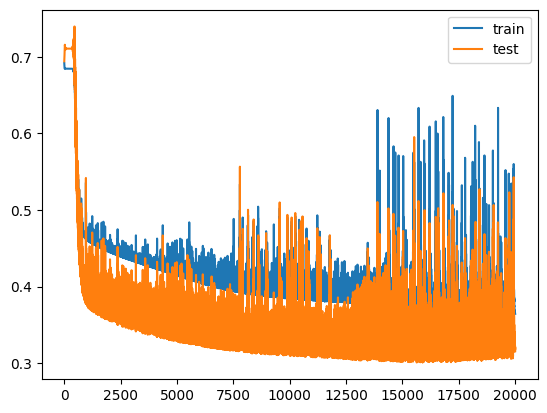

In [37]:
lossi = []
devlossi = []

for epoch in tqdm(range(20000)):
    out = model.forward(X_train)

    optimizer.zero_grad()
    loss = criterion(out, y_train)

    loss.backward()
    lossi.append(loss.item())
    optimizer.step()
    with torch.no_grad():
        devout = model.forward(X_test)
        devloss  = criterion(devout, y_test)
        devlossi.append(devloss.item())

plt.plot(lossi, label='train')
plt.plot(devlossi, label='test')
plt.legend()
plt.show()


In [38]:
print('lossi',min(lossi))
print('devlossi',min(devlossi),'\n')



with torch.no_grad():
    pred = model.forward(X_test)

pred = pred.round()

print(classification_report(y_true=y_test, y_pred=pred))

lossi 0.3620997965335846
devlossi 0.300837904214859 

              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88        53
         1.0       0.84      0.91      0.88        46

    accuracy                           0.88        99
   macro avg       0.88      0.88      0.88        99
weighted avg       0.88      0.88      0.88        99



### **Great, now we've got our results, let's think and see what we learned!** 

**Lesson 01.0: Best Model Selection** 

First, it's important to note that a proper training loop would evaluate the forward pass on the dev set (**validation set**). If the dev set loss is lower than the test set loss, **save that model** as the new best model 🤌.    Currently, we're only evaluating the last model❌, which might not always be the best.  If we saved the best model, we'd have the one where the dev set loss starts to go back up (**overfitting**). 

**Lesson 01.1: Deeper vs. Wider Models** ⚖️

Deeper models are generally better than wider ones, but most importantly, follow the principle of Occam's Razor 🗡️(**all else equal the simplest solution is the best**).  As you can see, the bigger models took longer to train (**especially the wider one**),  and had worse results👎, which might be puzzling. We might think bigger models could learn more complex relationships and find a better solution 🤷.  While that's true, the loss surface of a big model is huge, and it has to traverse much more space to find the optimal solution 👨‍🦯‍➡️. So, given enough time and training examples, our bigger models would do better, but at a cost of time and computational resources.  It's sufficient to say the first model was the better one.  

**Lesson 01.2: Become One with the Data** ☯️☯️ 

This might seem like a bonus lesson, but it's really foundational (*should be Lesson -1*).  If you've been learning about neural networks for a bit, you've probably seen that the test loss is often worse than the training loss.  This means the model you just trained is having trouble generalizing to unseen data. This is such a common issue that two big areas of research in neural networks are:

1. **Optimization:** How do we find the best minimum in our loss surface? 
2. **Regularization:**  How do we make our model generalize well to new data and not just memorize the training set?  

So, given that generalization is such a crucial issue, how is it that sometimes our test set is doing better than the training set?  


### What did we forget to do? Let's explore that next!

**Let's resample the data and see what happens!**  

We'll use the same model architecture for now, but let's just shuffle the data and see if it makes a difference  .  This might seem like a simple step, but it's crucial!  


In [43]:
#split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:].values, df.iloc[:, 0].values, test_size=0.2)

# normalize X_train and X_test
scaler_X = MinMaxScaler()
X_train = torch.tensor(scaler_X.fit_transform(X_train), dtype=torch.float32)
X_test = torch.tensor(scaler_X.transform(X_test), dtype=torch.float32)

# tensorizer :) y_train and y_test
y_train = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
y_test = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

In [44]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.l0 = nn.Linear(7,5)
        self.relu0 = nn.ReLU()
        self.l1 = nn.Linear(5,3)
        self.relu1 = nn.ReLU()
        self.l2 = nn.Linear(3,1)
        self.out = nn.Sigmoid()

    
    def forward(self,X):
        x = self.l0(X)
        x = self.relu0(x)
        x = self.l1(x)
        x = self.relu1(x)
        logits = self.l2(x)
        x = self.out(logits)
        return x
    
model = MLP()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.BCELoss()

100%|██████████| 20000/20000 [00:05<00:00, 3484.52it/s]


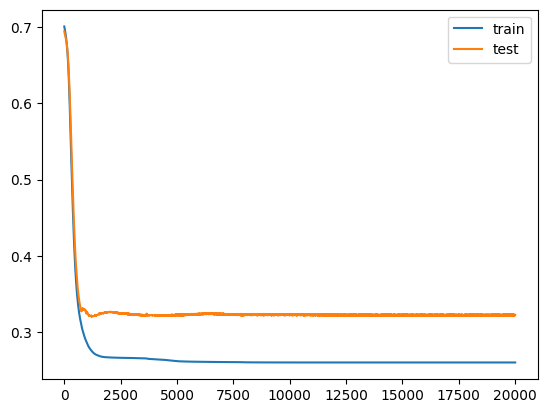

In [45]:
lossi = []
devlossi = []

for epoch in tqdm(range(20000)):
    out = model.forward(X_train)

    optimizer.zero_grad()
    loss = criterion(out, y_train)

    loss.backward()
    lossi.append(loss.item())
    optimizer.step()

    #evaluate the test loss but with no gradients
    with torch.no_grad():
        devout = model.forward(X_test)
        devloss  = criterion(devout, y_test)
        devlossi.append(devloss.item())

#plot the train loss and the test loss
plt.plot(lossi, label='train')
plt.plot(devlossi, label='test')
plt.legend()
plt.show()


In [46]:
#evaluation time
print('lossi',min(lossi))
print('devlossi',min(devlossi),'\n')



with torch.no_grad():
    pred = model.forward(X_test)

pred = pred.round() #our prediticons look like [.334, .638, .....] inorder to evalute we need them to be [0, 1, ....] so we round

print(classification_report(y_true=y_test, y_pred=pred))

lossi 0.2606104016304016
devlossi 0.32085976004600525 

              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87        44
         1.0       0.94      0.84      0.88        55

    accuracy                           0.88        99
   macro avg       0.88      0.88      0.88        99
weighted avg       0.89      0.88      0.88        99



### 🔍 **Interesting! Same Architecture, Different Results** 🔍

We used the same architecture and trained the model for the same number of epochs. The only thing that really changed was our training and test set. Note that since we reinitialized the model, the weights are different, meaning we found a different spot (minimum) in the loss surface. This might be less optimal, but let's gloss over that argument for now. Crucially, the training loss is now 0.26, compared to 0.42 before. This means we found a better spot in the loss surface to minimize the training loss this time. However, there's more to the story...


We're doing worse on the test set now than before. This could be due to a few things, like **overfitting** on the training set. 🤔

When overfitting occurs, your test loss curves often look like a **U** (see the image below). At a certain point, your test set starts to perform worse, but your training set keeps "learning" (the weights are just memorizing the training set, not generalizing to unseen data). 📉


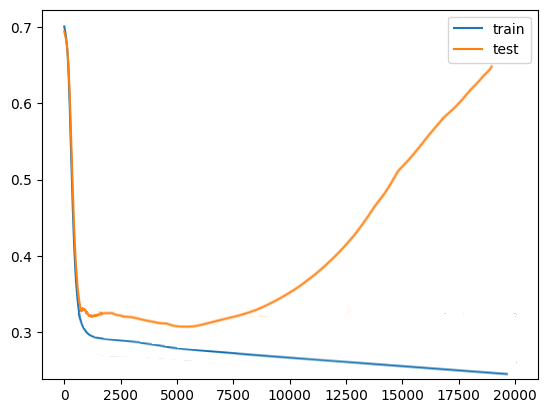



But our loss curve doesn't look like that! Instead, our loss curve (look at the graph after the training loop) just keeps getting systematically worse on the test set. This is where we emphasize *Lesson -1*: **Become one with the data!** ☯️

Our data is ~400-ish houses in San Francisco or New York City, each with 7 features. Let's plot the distribution of the elevation feature to see if there are any insights there... 📊

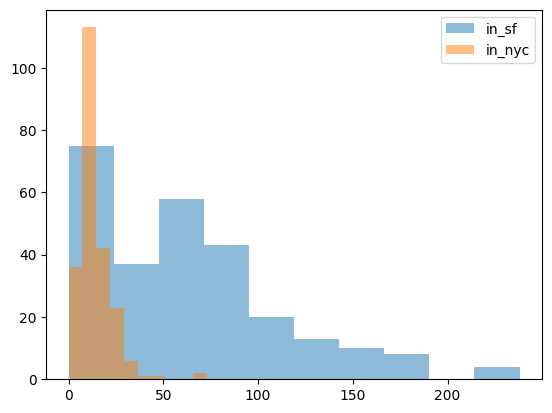

In [87]:
df_in_sf = df[df['in_sf'] == True]
df_not_in_sf = df[df['in_sf'] == False]

plt.figure()
plt.hist(df_in_sf['elevation'], alpha=0.5, label='in_sf')
plt.hist(df_not_in_sf['elevation'], alpha=0.5, label='in_nyc')
plt.legend()
plt.show()

In [138]:
#see how many in sf and nyc are under 50 elevation

#first we get a series that true or false 
sf_under_50_series = (df['in_sf'] == 1) & (df['elevation'] <= 50)
sf_over_50_series = (df['in_sf'] == 1) & (df['elevation'] > 50)

nyc_under_50_series = (df['in_sf'] == 0) & (df['elevation'] <= 50)
nyc_over_50_series = (df['in_sf'] == 0) & (df['elevation'] > 50)


sf_under_50, nyc_under_50 = sf_under_50_series.sum() , nyc_under_50_series.sum()
sf_over_50, nyc_over_50 = sf_over_50_series.sum() , nyc_over_50_series.sum()


print(f'SF has #{sf_under_50} under fifty elevation and #{sf_over_50} over fifty elevation.\nNYC has #{nyc_under_50} under fifty elevation and #{nyc_over_50} over fifty elevation.')

SF has #121 under fifty elevation and #147 over fifty elevation.
NYC has #221 under fifty elevation and #3 over fifty elevation.


### 💡 **Aha! This is Interesting!** 💡

We can see that almost every house over 50 elevation is in San Francisco. That's a very easy split for the model to learn. 🌉

If we split the training and test sets randomly, there's a chance the test set could have a lot of houses above 50 elevation (which are easy, since they're almost always in SF). The training set might then have many houses under 50 elevation (which are harder to classify). 🏡

Let's put some random subsets of our data through the model and see the results...

**Note:** We will be using the data we trained on, which is a big no-no, but we are not exploring the ability to generalize well right now. Instead, we are focusing on the need to understand your data well. 🧠📊

In [144]:
#split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:].values, df.iloc[:, 0].values, test_size=0.2)

# normalize X_train and X_test
scaler_X = MinMaxScaler()
X_train = torch.tensor(scaler_X.fit_transform(X_train), dtype=torch.float32)
X_test = torch.tensor(scaler_X.transform(X_test), dtype=torch.float32)

# tensorizer :) y_train and y_test
y_train = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
y_test = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

with torch.no_grad():
    pred = model.forward(X_test)

pred = pred.round() 

print('For the new test set:')
print(classification_report(y_true=y_test, y_pred=pred))

For the new test set:
              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93        46
         1.0       0.98      0.89      0.93        53

    accuracy                           0.93        99
   macro avg       0.93      0.93      0.93        99
weighted avg       0.93      0.93      0.93        99



### 🎉 Success with a Subset! 🎉

Ok, so for this subset of the data, we did way better! 📈


In [242]:
#split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:].values, df.iloc[:, 0].values, test_size=0.2)

# normalize X_train and X_test
scaler_X = MinMaxScaler()
X_train = torch.tensor(scaler_X.fit_transform(X_train), dtype=torch.float32)
X_test = torch.tensor(scaler_X.transform(X_test), dtype=torch.float32)

# tensorizer :) y_train and y_test
y_train = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
y_test = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

with torch.no_grad():
    pred = model.forward(X_test)

pred = pred.round() 

print('For the new test set:')
print(classification_report(y_true=y_test, y_pred=pred))

For the new test set:
              precision    recall  f1-score   support

         0.0       0.71      0.91      0.80        35
         1.0       0.94      0.80      0.86        64

    accuracy                           0.84        99
   macro avg       0.83      0.86      0.83        99
weighted avg       0.86      0.84      0.84        99



### 😲 Wow, This One Did Worse 😲

Wow, but on this one, we did way worse. 📉

### 🧠 Lessons Learned 🧠

So the lesson here is that our model was doing some funky things, such as the test set performing better than the train set and the model having big variances depending on which samples we select. Now, these problems can arise for many reasons (e.g., too small of a test size with too much variance can cause it to evaluate funkily), but the point here is that the first step is to know your data well and become one with the data before starting to build models. 

Because we knew that our data had samples that were very easy and some very hard ones, and that there was a larger variation in the difficulty of the samples, we knew the issues we were running into. 🧩🔍

> As the great Obi-Wan Kenobi said: "Become one with the Force." Or in our case, become one with the data, deep learning jedis. 🧙‍♂️✨
